**Mounting google drive into Colab**

In [1]:
#mounting google drive into collab, using (force_remount = True) for getting dynamic changes into drive folder into consideration
#getting access to the Corel5K 
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'MLProject769/Corel5K' 
assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive
%cd $FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/MLProject769/Corel5K


In [2]:
#getting current working directory
import os
cwd = os.getcwd()
print(cwd)

/content/drive/My Drive/MLProject769/Corel5K


In [5]:
#Importing  libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

from keras.utils import np_utils
from keras.applications import imagenet_utils


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from sklearn.metrics.pairwise import cosine_similarity
from numpy import dot
from numpy.linalg import norm

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt; 

from sklearn import svm,calibration 

from keras.models import Sequential,Model

# **Reading Coral5K dataset Images from the Given path**

---
Divide the images into train,test and validation
out of 5K images 3K images for training
                 1K images for testing
                 1K images for validation


In [8]:
data = np.array([img for img in os.listdir(cwd)])
# print(data[:10])
data_y = np.array([int(img.split("_")[0]) for img in data])
# print(data_y[:30])

train,test,train_y,test_y =train_test_split(data,data_y,test_size=0.4, 
                                            random_state=123,stratify = data_y)

test,val,test_y,val_y =train_test_split(test,test_y,test_size=0.5, 
                                            random_state=123,stratify = test_y)

# print(train.shape,test.shape,val.shape)

# **Importing ResNet50 model trained on Imagenet**


---
We will use this model for transfer learning
As this will be used only for Feature Extraction, we import the complete Resnet50 model except the layer used for classification (Hence include_top = False)


In [9]:
# Importing Pre-trained Model ResNet50
model = ResNet50(weights='imagenet',include_top = False,input_shape=(224, 224, 3))
print(model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

# **Extracting Features**

---



In [10]:
# Function to extract features
def create_features(dataset, pre_model):
 
    x_scratch = []
 
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
 
        # add the image to the batch
        x_scratch.append(image)
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    features_flatten = features.reshape((features.shape[0], 7 * 7 * 2048))
    return x, features, features_flatten


# Extracting Features

train_x, train_features, train_features_flatten = create_features(train, model)
print(train_x.shape, train_features.shape, train_features_flatten.shape)

test_x, test_features, test_features_flatten = create_features(test, model)
print(test_x.shape, test_features.shape, test_features_flatten.shape)

val_x, val_features, val_features_flatten = create_features(val, model) 
print(val_x.shape, val_features.shape, val_features_flatten.shape)

(3000, 224, 224, 3) (3000, 7, 7, 2048) (3000, 100352)
(1000, 224, 224, 3) (1000, 7, 7, 2048) (1000, 100352)
(1000, 224, 224, 3) (1000, 7, 7, 2048) (1000, 100352)


In [11]:
# Data frame for features
df = pd.DataFrame(train_features_flatten.T)
df.columns = train
print(df.columns.values)

['13_1315.jpg' '36_3610.jpg' '47_4757.jpg' ... '25_2524.jpg' '6_677.jpg'
 '33_3323.jpg']


# **Linear SVM Classifier**

---
Image Classification Requires probabilities output by Classifier \\
As per the Official Documentation of "sklearn", classifiers other than LinearSVM (in svc family) predicted output may not match with the probabilities. \\
 \\
Hence we will use LinearSVC for Classification. \\
using training data we will train LinearSVM and then using test data we would calibrate the LinearSVM to give the correct probabilities. \\

Then we would check the classifier performance on Validation data.


**Classifier on training data**

In [12]:
clf_SVM = svm.LinearSVC(multi_class='ovr')
clf_SVM.fit(train_features_flatten,train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

**CalibrationClassifierCV on test data** 

In [13]:
clf =  calibration.CalibratedClassifierCV(base_estimator = clf_SVM,cv ='prefit')
clf.fit(test_features_flatten,test_y)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=True, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv='prefit', method='sigmoid')

In [14]:
z1 = clf.predict(train_features_flatten)


z2 = clf.predict(test_features_flatten)


z3 = clf.predict(val_features_flatten)

train_report = classification_report(train_y,z1)
test_report = classification_report(test_y,z2)
val_report = classification_report(val_y,z3)
print("Classification report of Linear SVM on Training data : ",'\n',train_report)
print("Classification report of Linear SVM on Testing data : ",'\n',test_report)
print("Classification report of Linear SVM on Validation data : ",'\n',val_report)

Classification report of Linear SVM on Training data :  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        60
           6       1.00      1.00      1.00        60
           7       1.00      1.00      1.00        60
           8       1.00      1.00      1.00        60
           9       1.00      1.00      1.00        60
          10       1.00      1.00      1.00        60
          11       1.00      1.00      1.00        60
          12       1.00      1.00      1.00        60
          13       1.00      1.00      1.00        60
          14       1.00      1.00      1.00        60
          15       1.00      1.00      1.00        60
          16       1.00

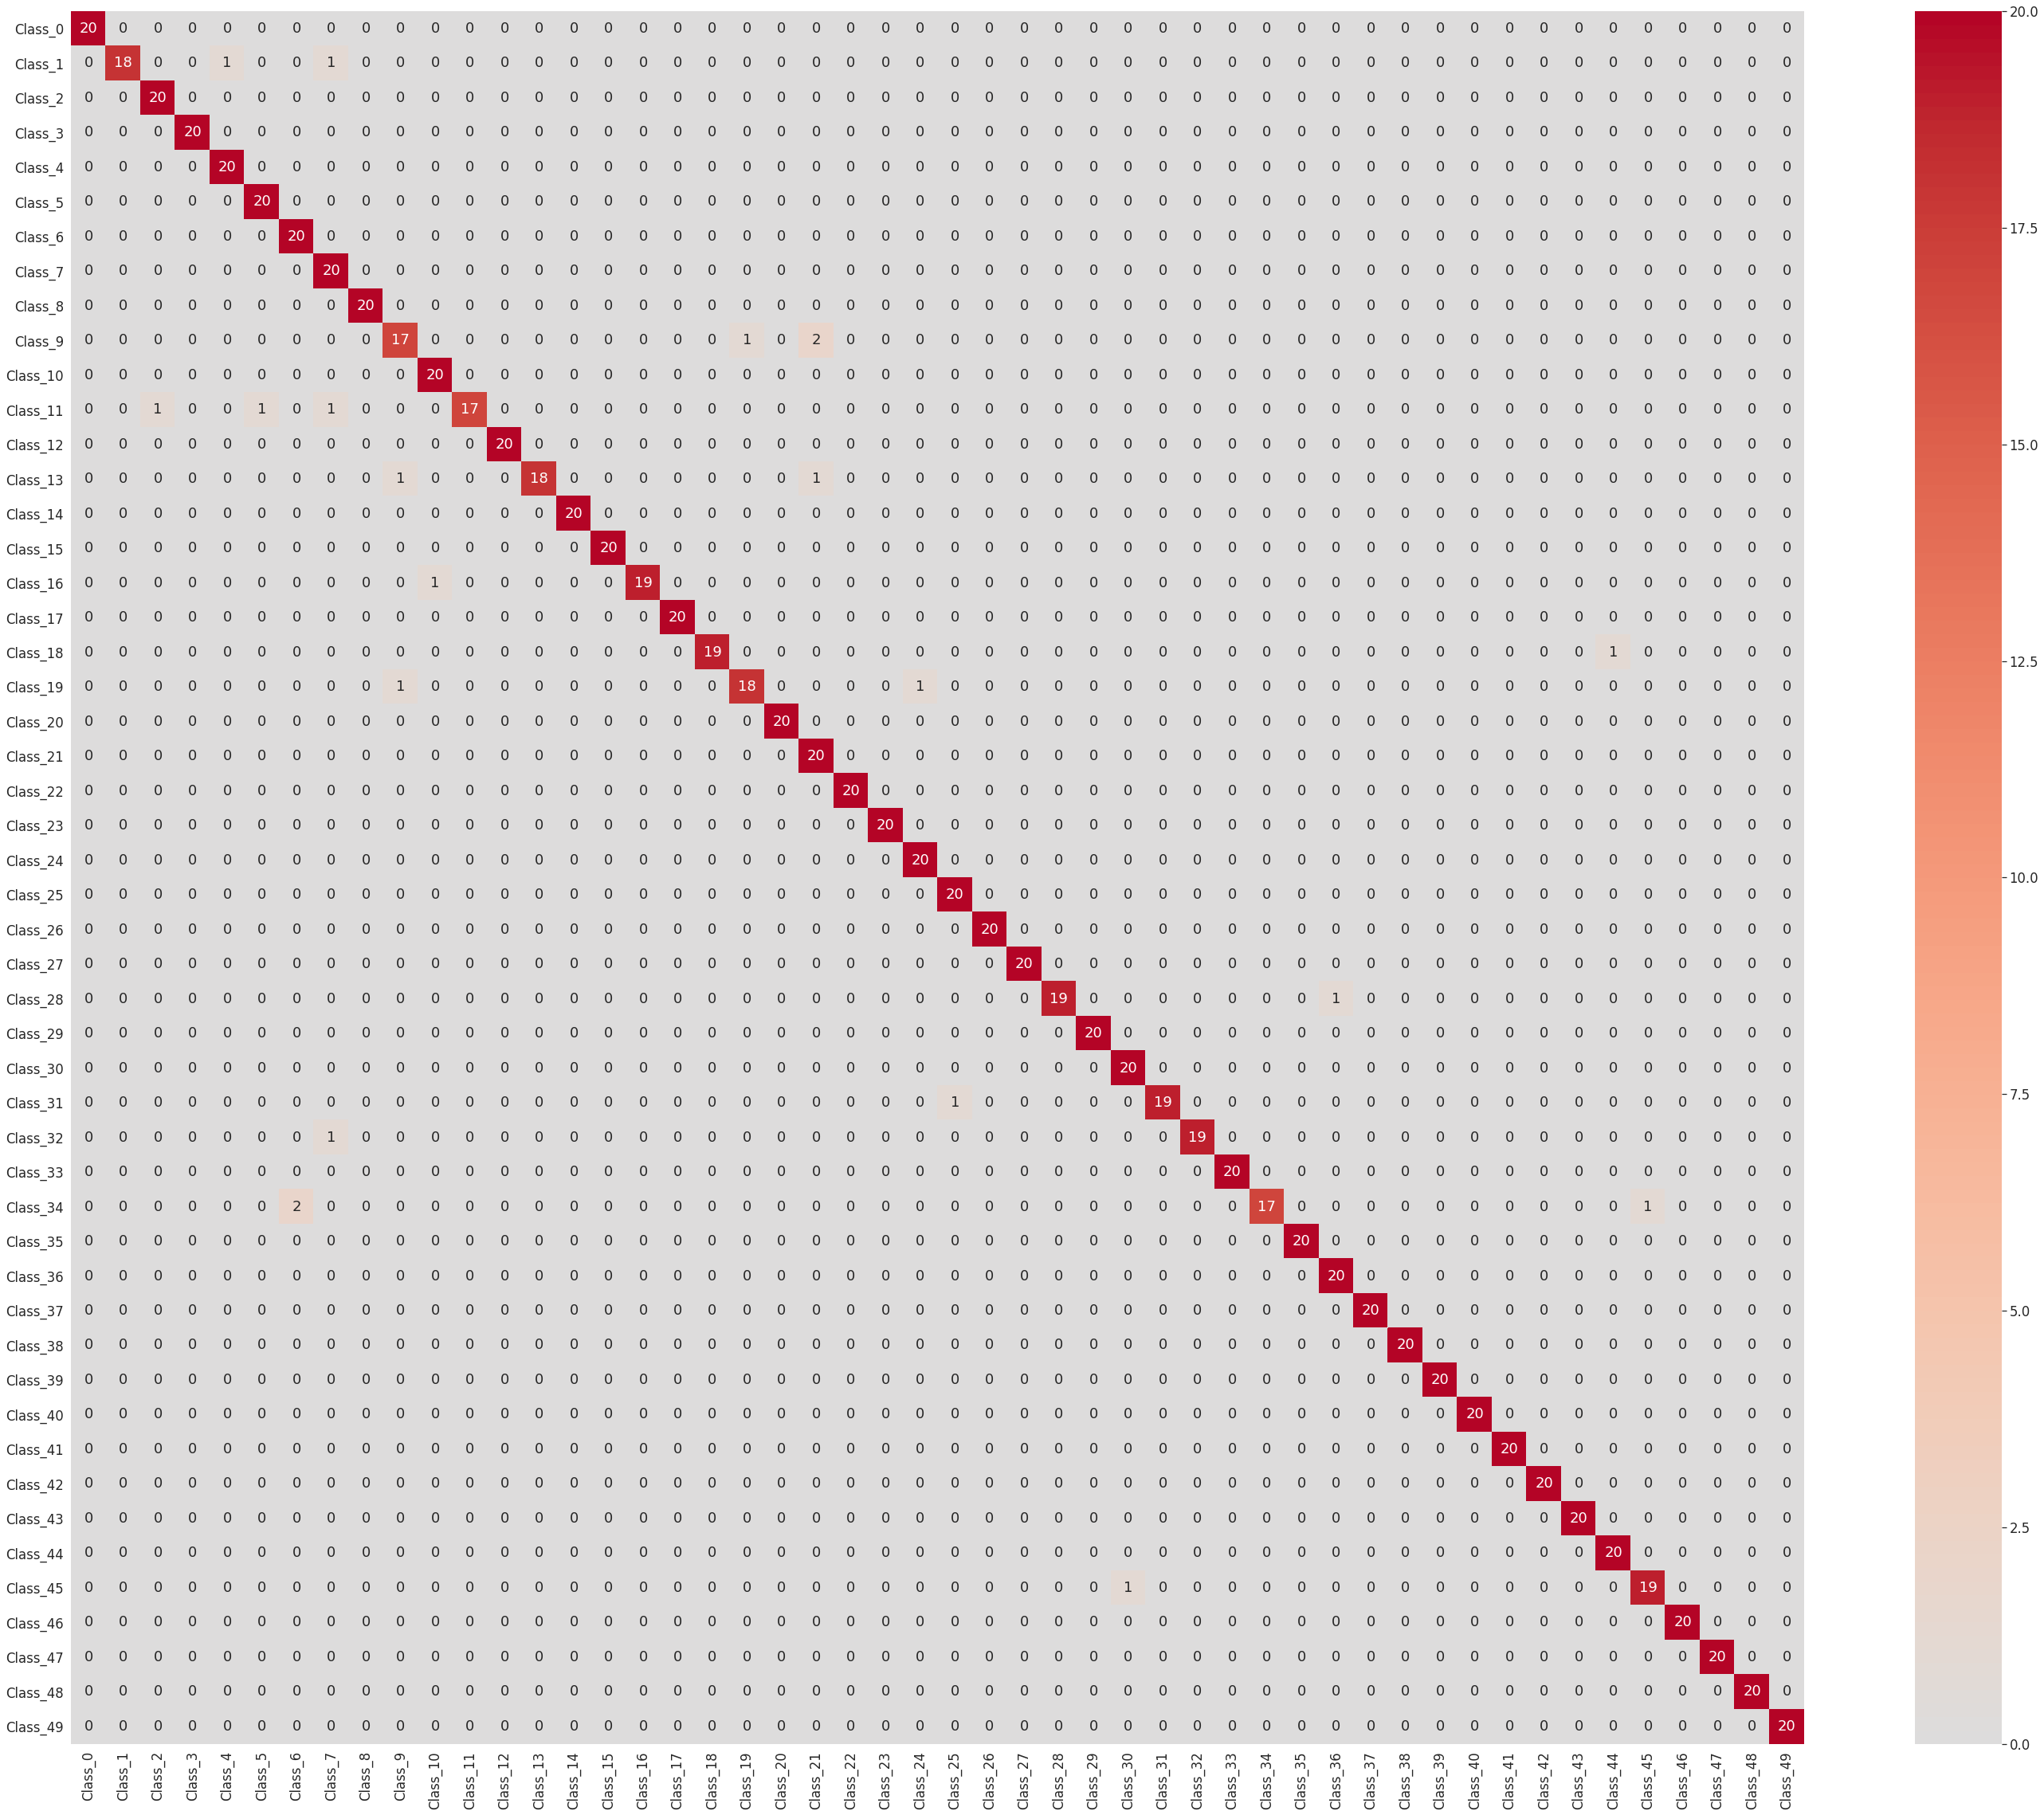

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_ =['Class_%i'%i for i in range(50) ]

confmat = confusion_matrix(y_true=val_y, y_pred=z3)

plt.figure(figsize=(50,40))   ## Plot the heat map to check correlation between features
sns.set(font_scale=1.5)
sns.heatmap(confmat,cmap='coolwarm',annot=True,square=True,cbar=True,center=0,fmt="d",
                 yticklabels=class_,
                 xticklabels=class_)


# **Query Image 1 and Classifier Prediction**

In [27]:
# Query Image 1

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
preds = preds.reshape((preds.shape[0], -1))

#Classifier Prediction
y =clf.predict_proba(preds)  # gives probability of each class in classification
y1 = clf.predict(preds)   #gives classification class only


print(y)
print(y1)

[[0.0090563  0.04203791 0.00581665 0.00457229 0.33714973 0.00321893
  0.00389549 0.02888465 0.00535763 0.01609981 0.00625125 0.01046594
  0.01263232 0.06183604 0.01599572 0.00459262 0.0075702  0.03694153
  0.00834047 0.00877098 0.00759288 0.01007759 0.00621089 0.00222672
  0.0089278  0.04250194 0.00688705 0.00163378 0.01809926 0.00742629
  0.00075645 0.01103519 0.00568728 0.02286445 0.00324665 0.00805983
  0.01118357 0.03955376 0.00807617 0.01425263 0.0471624  0.00673163
  0.0122549  0.00335963 0.00661826 0.01145617 0.00790801 0.00672093
  0.01566527 0.01633612]]
[4]


# **Chossing 2 best classes from Classifier**

---



In [28]:
#Choosing the best 2 classes of classification (class with highest probability)
zz = np.argsort(list(np.ravel(y)))[:-3:-1]


#Chossing all the images of Classes selected above
data1 = list(filter(lambda x:(int(x.split(".")[0].split("_")[0])==zz[0]) | (int(x.split(".")[0].split("_")[0])==zz[1]),train))

print(zz,data1)


[ 4 13] ['13_1315.jpg', '4_437.jpg', '4_456.jpg', '13_1314.jpg', '4_439.jpg', '4_435.jpg', '4_442.jpg', '4_423.jpg', '4_426.jpg', '4_465.jpg', '13_1317.jpg', '4_414.jpg', '13_1312.jpg', '13_1378.jpg', '4_498.jpg', '4_448.jpg', '13_1302.jpg', '13_1358.jpg', '4_484.jpg', '13_1321.jpg', '13_1362.jpg', '4_436.jpg', '13_1331.jpg', '4_497.jpg', '13_1381.jpg', '13_1338.jpg', '4_491.jpg', '13_1346.jpg', '13_1389.jpg', '13_1343.jpg', '4_493.jpg', '13_1347.jpg', '13_1327.jpg', '13_1359.jpg', '4_429.jpg', '13_1310.jpg', '4_473.jpg', '4_500.jpg', '13_1341.jpg', '4_482.jpg', '4_464.jpg', '13_1385.jpg', '4_403.jpg', '13_1363.jpg', '4_443.jpg', '13_1309.jpg', '13_1307.jpg', '13_1361.jpg', '4_401.jpg', '4_419.jpg', '4_470.jpg', '13_1301.jpg', '4_457.jpg', '13_1308.jpg', '4_447.jpg', '13_1318.jpg', '13_1344.jpg', '13_1397.jpg', '4_478.jpg', '13_1372.jpg', '13_1384.jpg', '4_406.jpg', '13_1319.jpg', '4_489.jpg', '13_1323.jpg', '4_431.jpg', '13_1350.jpg', '4_421.jpg', '4_455.jpg', '13_1355.jpg', '4_466.jp

# **Similarity Measure**

---



In [29]:
# finding Similarity Measure Cosine Similarity
result=[]
for i in data1 :
  x = list(cosine_similarity(preds,np.array([df[i]])))
  result.append(x[0][0])

yy = [data1[i] for i in np.argsort(result)[:-13:-1]]
print(yy)
print(result)

['4_493.jpg', '4_439.jpg', '4_431.jpg', '4_473.jpg', '4_428.jpg', '4_461.jpg', '4_430.jpg', '4_417.jpg', '4_402.jpg', '4_482.jpg', '4_429.jpg', '4_440.jpg']
[0.109774426, 0.21591854, 0.24306871, 0.10569791, 0.34170097, 0.26597032, 0.22011957, 0.24585226, 0.18538839, 0.25450376, 0.108608596, 0.21617633, 0.11907297, 0.09451128, 0.13972431, 0.20154676, 0.08777207, 0.13559815, 0.17729187, 0.08117616, 0.09330641, 0.1785414, 0.09768109, 0.20496929, 0.08408353, 0.11057124, 0.21331769, 0.107322544, 0.097870804, 0.13540241, 0.34520468, 0.084807135, 0.13168146, 0.12616985, 0.27249837, 0.12780422, 0.33432955, 0.22779956, 0.08118385, 0.28631496, 0.20968139, 0.107285656, 0.1819494, 0.09957919, 0.27091885, 0.12855428, 0.10525271, 0.070892684, 0.23155072, 0.2357522, 0.24826023, 0.09935936, 0.21815795, 0.12871902, 0.22914827, 0.10168365, 0.12626418, 0.10143349, 0.20176622, 0.1152999, 0.10383156, 0.25820845, 0.1342079, 0.2509299, 0.11950408, 0.33688557, 0.13537747, 0.2678042, 0.25240004, 0.1241256, 0.1

# **Displaying top 12 Similar images to Query Image 1**

---



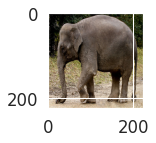

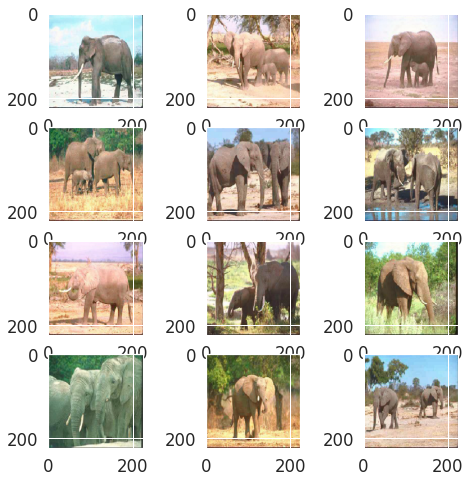

In [30]:
# printing Query image
plt.figure(figsize=(1.75, 1.75))
im = load_img('elephant.jpg', target_size=(224, 224))
plt.imshow(im)
plt.show()

def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,3):
            image = load_img(X[k], target_size=(224, 224))
            plt.subplot2grid((4,3),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

show_imgs(yy)

# **Precision Recall Curve of SVM**

In [31]:
val_score_SVM = clf.predict_proba(val_features_flatten)

In [33]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

y_train = lb.fit_transform(train_y)
y_val = lb.fit_transform(val_y)
y_test = lb.fit_transform(test_y)

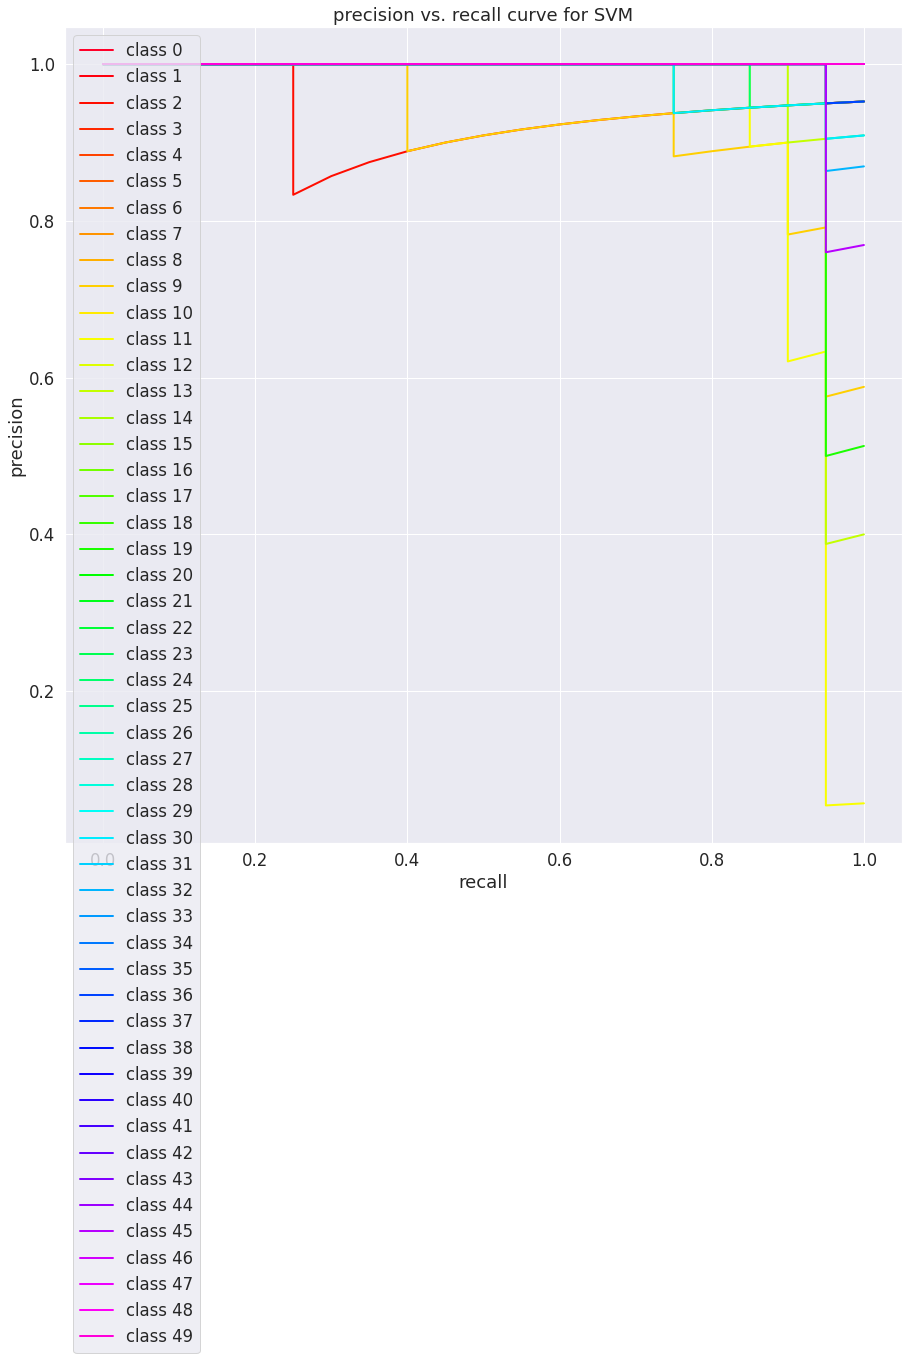

In [34]:
from sklearn.metrics import precision_recall_curve, roc_curve
precision = dict()
recall = dict()
plt.figure(figsize=(15,15))
import pylab
NUM_COLORS = 50
cm = pylab.get_cmap('gist_rainbow')
for i in range(50):
    precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],val_score_SVM[:, i])
    color = cm(1.*i/NUM_COLORS)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i),color=color)


plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve for SVM")
plt.show()


# **Query Image 2 and Classifier Prediction**

In [36]:
# Query Image 2

img_path = 'polarbear.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
preds = preds.reshape((preds.shape[0], -1))

#Classifier Prediction
y =clf.predict_proba(preds)  # gives probability of each class in classification
y1 = clf.predict(preds)   #gives classification class only


print(y)
print(y1)

[[1.47079408e-03 6.12092535e-01 7.30443021e-02 2.20298552e-04
  1.94542696e-03 4.76381859e-04 6.86022430e-04 6.06010410e-04
  2.28300377e-03 1.76994434e-03 2.03003233e-03 1.37198416e-01
  1.05664089e-03 2.17165106e-02 1.21555835e-02 1.69225718e-03
  2.49096982e-04 1.65832907e-02 7.51308775e-03 2.16650997e-03
  3.28835710e-03 1.79866535e-03 4.82898046e-04 1.02002769e-03
  3.74840755e-03 1.72811991e-02 6.42321103e-05 2.62591787e-03
  5.07395073e-03 7.71936705e-03 5.52323642e-04 1.91278006e-03
  1.27359273e-03 6.26749385e-03 2.69218538e-03 1.57856467e-03
  1.55449648e-03 1.44136173e-03 7.49169315e-04 4.32372146e-03
  2.55009806e-03 1.37493499e-03 1.54764634e-02 2.74341343e-03
  4.28210924e-04 2.60716016e-04 7.58871697e-03 2.52630575e-03
  3.35835469e-03 1.28792882e-03]]
[1]


# **Choosing 2 best classes from Classifier fo Query Image 2**

---



In [37]:
#Choosing the best 2 classes of classification (class with highest probability)
zz = np.argsort(list(np.ravel(y)))[:-3:-1]


#Chossing all the images of Classes selected above
data1 = list(filter(lambda x:(int(x.split(".")[0].split("_")[0])==zz[0]) | (int(x.split(".")[0].split("_")[0])==zz[1]),train))

print(zz,data1)

[ 1 11] ['11_1102.jpg', '1_181.jpg', '1_118.jpg', '1_186.jpg', '11_1123.jpg', '11_1112.jpg', '11_1153.jpg', '1_146.jpg', '1_123.jpg', '11_1179.jpg', '11_1121.jpg', '11_1177.jpg', '11_1163.jpg', '11_1130.jpg', '11_1167.jpg', '11_1115.jpg', '1_128.jpg', '11_1159.jpg', '11_1197.jpg', '11_1154.jpg', '11_1162.jpg', '11_1185.jpg', '11_1124.jpg', '1_182.jpg', '11_1117.jpg', '1_150.jpg', '1_108.jpg', '11_1122.jpg', '11_1182.jpg', '11_1110.jpg', '11_1198.jpg', '11_1166.jpg', '11_1180.jpg', '1_180.jpg', '11_1131.jpg', '1_103.jpg', '11_1114.jpg', '1_184.jpg', '1_169.jpg', '11_1193.jpg', '1_200.jpg', '1_168.jpg', '1_131.jpg', '1_160.jpg', '11_1129.jpg', '1_130.jpg', '1_122.jpg', '11_1104.jpg', '11_1107.jpg', '1_106.jpg', '1_101.jpg', '1_155.jpg', '11_1186.jpg', '11_1105.jpg', '1_102.jpg', '1_105.jpg', '1_109.jpg', '11_1189.jpg', '1_176.jpg', '1_115.jpg', '11_1119.jpg', '11_1158.jpg', '1_147.jpg', '11_1101.jpg', '1_167.jpg', '1_183.jpg', '1_145.jpg', '11_1157.jpg', '1_117.jpg', '1_135.jpg', '11_110

# **Similarity Measure for Query Image 2**

---



In [38]:
# finding Similarity Measure Cosine Similarity
result=[]
for i in data1 :
  x = list(cosine_similarity(preds,np.array([df[i]])))
  result.append(x[0][0])

yy = [data1[i] for i in np.argsort(result)[:-13:-1]]
print(yy)
print(result)

['1_131.jpg', '1_111.jpg', '1_116.jpg', '1_105.jpg', '1_109.jpg', '1_117.jpg', '1_175.jpg', '1_182.jpg', '1_110.jpg', '1_119.jpg', '1_180.jpg', '1_104.jpg']
[0.17508832, 0.19132891, 0.21995789, 0.19784322, 0.15581042, 0.14490023, 0.21927655, 0.22473693, 0.32744578, 0.24941817, 0.20939422, 0.24552506, 0.18638618, 0.16489212, 0.1517114, 0.10942836, 0.31684345, 0.13132146, 0.24468023, 0.1590014, 0.157809, 0.16029182, 0.17843075, 0.36473465, 0.19094369, 0.17697492, 0.17969927, 0.22132559, 0.1107357, 0.24036083, 0.30649155, 0.15889221, 0.18301176, 0.35441762, 0.17045298, 0.29811594, 0.15877497, 0.26919794, 0.08035939, 0.13632813, 0.31136525, 0.20205331, 0.5369127, 0.26921958, 0.13704357, 0.348303, 0.23417607, 0.17614885, 0.14991355, 0.21060193, 0.32368356, 0.25190485, 0.15743946, 0.1679919, 0.3052158, 0.40033388, 0.3998692, 0.1366572, 0.20139259, 0.2498021, 0.17592332, 0.16602182, 0.17301667, 0.1901983, 0.19463238, 0.21938467, 0.23549755, 0.13734591, 0.39010784, 0.3378743, 0.14511515, 0.161

# **Displaying top 12 Similar images to Query Image 2**

---



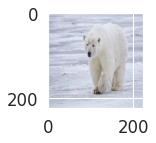

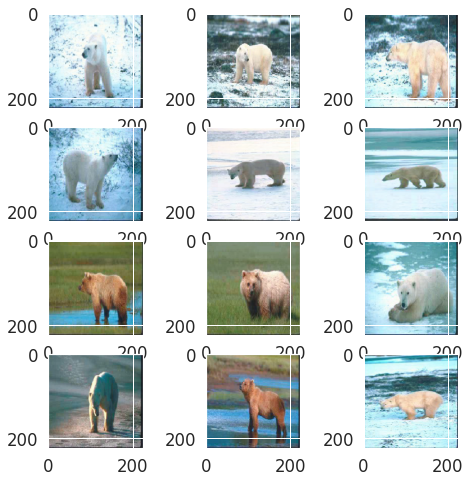

In [39]:
# printing Query image
plt.figure(figsize=(1.75, 1.75))
im = load_img('polarbear.jpg', target_size=(224, 224))
plt.imshow(im)
plt.show()

def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,3):
            image = load_img(X[k], target_size=(224, 224))
            plt.subplot2grid((4,3),(i,j))
            plt.imshow(image)
            k = k+1
    # show the plot
    plt.show()

show_imgs(yy)